In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys

sys.path += ['../src/']

In [3]:
from pathlib import Path

import cv2
import numpy as np
from PIL import Image

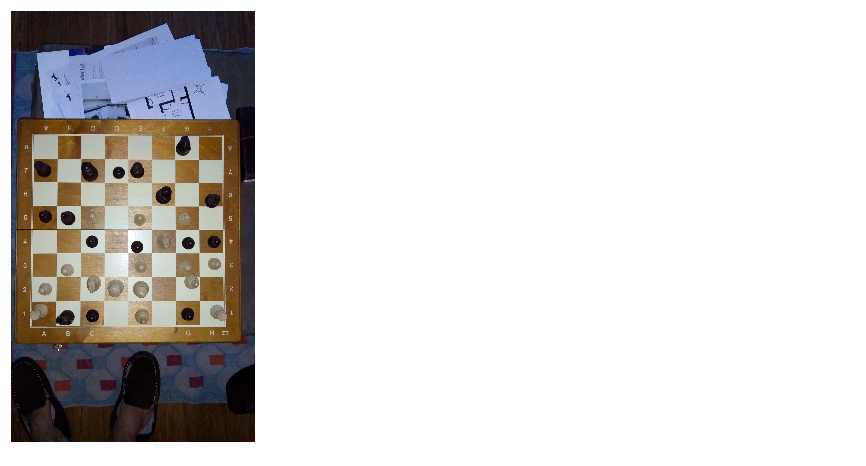

In [4]:
from itertools import chain  

FAIL_BOARD = '../data/raw/RandomLinesFails.jpg'
board_image = Image.open(FAIL_BOARD, 'r')

def show(*pil_images, n_img_per_row=3, figsize=(12, 6)):    
    n_images = len(pil_images)

    fig, axe_matrix = plt.subplots(1 + n_images // n_img_per_row, n_img_per_row, squeeze=False)
    fig.set_size_inches(figsize)

    for i, pil_image in enumerate(pil_images):
        row, col = (i // n_img_per_row), i % n_img_per_row
        ax = axe_matrix[row, col]
        ax.imshow(np.asarray(pil_image))#, aspect='auto')
        ax.set_xticks([]); ax.set_yticks([]);

    for ax in chain.from_iterable(axe_matrix):
        ax.set_axis_off()
    fig.subplots_adjust(left=.001, bottom=.001, right=.999, top=.999, wspace=.001, hspace=.001)

show(board_image)

In [305]:
from chessid import detection
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(3264, 1840, 3)
0.01862928255541347


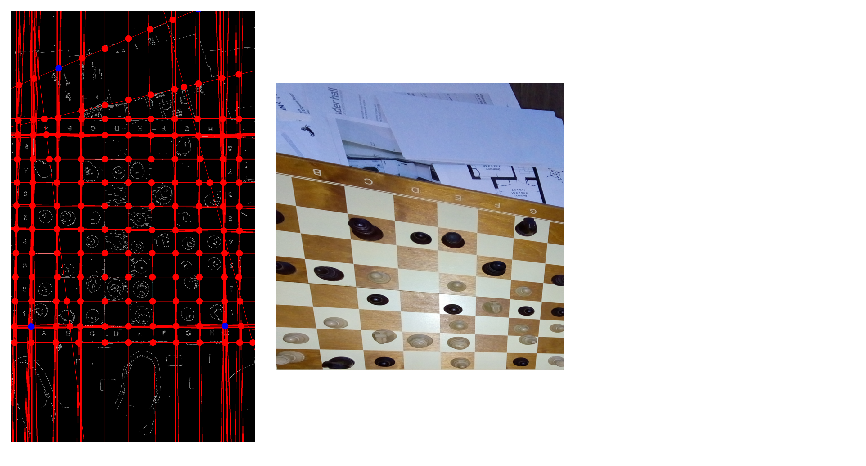

In [306]:
with Path(FAIL_BOARD).open('rb') as f:
    image = np.asarray(bytearray(f.read()))

result = detection.find_board(image)

show(result.debug, result.board)

In [128]:
from scipy import spatial

def only_inside_points(output_points, output_square_size, epsilon=1):
    inside_mask = np.logical_and(
        output_points >= -epsilon,
        output_points <= (8*output_square_size+epsilon)
    ).all(axis=1)
    return output_points[inside_mask, :]


def ideal_output_points(output_square_size):
    grid = np.linspace(start=0, stop=output_square_size * 8, num=8+1)
    return [(x, y) for x in grid for y in grid]


def closest_points_to_ideal_distances(points, output_square_size):
    ideal_points = ideal_output_points(output_square_size)
    real_to_ideal_distances = spatial.distance.cdist(points, ideal_points, 'euclidean')
    return real_to_ideal_distances


def show_points(points, *args, with_grid=False, **kwargs):
    x, y = zip(*points)
    plt.plot(x, -np.array(y), *args, **kwargs)
    if with_grid:
        plt.vlines(x=(0, 8*100), ymin=-800, ymax=0, colors='grey')
        plt.hlines(y=(0, -8*100), xmin=0, xmax=800, colors='grey')
    plt.xticks([]);plt.yticks([])

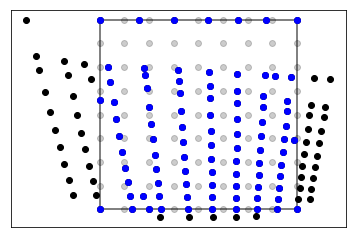

In [129]:
output_square_size = 100
output_points = detection.perspective_transform(result.corner_points, result.all_points, output_square_size)

show_points(ideal_output_points(output_square_size), 'ok', alpha=.2, with_grid=True)
show_points(output_points, 'ok', with_grid=True)
show_points(only_inside_points(output_points, output_square_size), 'ob', with_grid=True)

In [130]:
distances.shape

(85, 81)

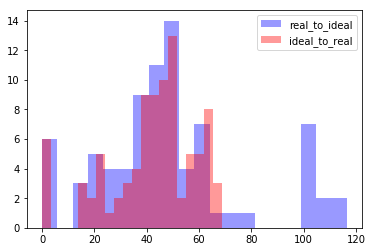

In [131]:
inside_points = only_inside_points(output_points, output_square_size)
distances = closest_points_to_ideal_distances(inside_points, output_square_size)

plt.hist(distances.min(axis=0), bins=20, color='blue', label='real_to_ideal', alpha=.4);
plt.hist(distances.min(axis=1), bins=20, color='red', label='ideal_to_real', alpha=.4);
plt.legend();

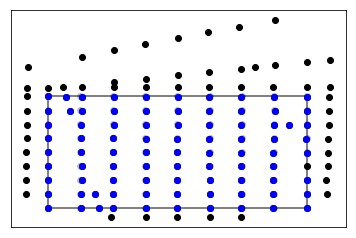

In [550]:
better_corners = [
 (167, 941),
 (152.79538, 2392.0168),
 (1614.2286, 2389.4658),
 (1596, 947)]

output_points = detection.perspective_transform(better_corners, result.all_points, output_square_size)

show_points(ideal_output_points(output_square_size), 'ok', alpha=.2, with_grid=True)
show_points(output_points, 'ok', with_grid=True)
show_points(only_inside_points(output_points, output_square_size), 'ob', with_grid=True)

(85, 81)
(81,)


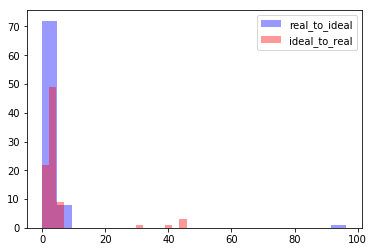

In [551]:
inside_points = only_inside_points(output_points, output_square_size)

distances = closest_points_to_ideal_distances(inside_points, output_square_size)

print(distances.shape)
print(distances.min(axis=0).shape)

plt.hist(distances.min(axis=0), bins=20, color='blue', label='real_to_ideal', alpha=.4);
plt.hist(distances.min(axis=1), bins=20, color='red', label='ideal_to_real', alpha=.4);
plt.legend();

## Stopping criterion

In [574]:
def mixed_distance(candidate_corner_points, all_points, output_square_size=100):
    output_points = detection.perspective_transform(candidate_corner_points, all_points, output_square_size)
    inside_points = only_inside_points(output_points, output_square_size)
    distances = closest_points_to_ideal_distances(inside_points, output_square_size)
    
    n_points = inside_points.shape[0]

    return np.mean(distances.min(axis=1)) + np.median(distances.min(axis=0)) + (n_points - 81) * (n_points - 81)


all_points = np.array(result.all_points, dtype=np.float32)
x_min, y_min = all_points.min(axis=0)
x_max, y_max = all_points.max(axis=0)

# initial candidates, has to be bottom left, top left, top right, ...
max_corner_points = np.array([[x_min, y_min], [x_min, y_max], [x_max, y_max], [x_max, y_min]])
closest_points_distances = spatial.distance.cdist(max_corner_points, all_points)

candidate_corner_points = all_points[closest_points_distances.argmin(axis=1), :]

print(mixed_distance(candidate_corner_points, all_points, output_square_size))
print(mixed_distance(better_corners, all_points, output_square_size))

168.30861950947562
24.59884028859595


In [105]:
% timeit median_distance(candidate_corner_points, all_points, output_square_size)

263 µs ± 7.57 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [514]:
from itertools import product


def topn_closest_to_corners_indexes(max_corner_points, all_points, topn=10):
    closest_points_distances = spatial.distance.cdist(max_corner_points, all_points)
    topn_closest_to_corners_indexes = np.argpartition(closest_points_distances, kth=topn, axis=1)[:, :topn]

    return (
        all_points[indexes, :]
        for indexes in product(*topn_closest_to_corners_indexes) 
        if len(set(indexes)) == 4)

candidate_corners = topn_closest_to_corners_indexes(max_corner_points, all_points, topn=5)

len(list(candidate_corners))

625

In [515]:
candidate_and_criteria = [
    (corners, mixed_distance(corners, all_points, output_square_size))
    for corners in topn_closest_to_corners_indexes(max_corner_points, all_points, topn=10)]

In [516]:
candidates, criteria = zip(*candidate_and_criteria)

print(min(criteria))

25.326252874906476


In [517]:
best_corners, criterium = candidate_and_criteria[np.argmin(criteria)]

criterium

25.326252874906476

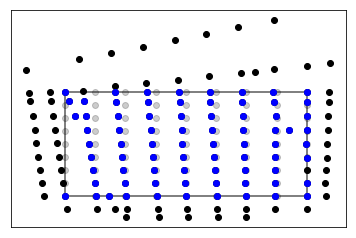

In [518]:
output_points = detection.perspective_transform(best_corners, result.all_points, output_square_size)

show_points(ideal_output_points(output_square_size), 'ok', alpha=.2, with_grid=True)
show_points(output_points, 'ok', with_grid=True)
show_points(only_inside_points(output_points, output_square_size), 'ob', with_grid=True)

In [519]:
topn=15
closest_points_distances = spatial.distance.cdist(max_corner_points, all_points)
topn_closest_to_corners_indexes = np.argpartition(closest_points_distances, kth=topn, axis=1)[:, :topn]

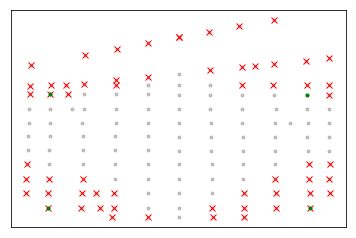

In [520]:
show_points(all_points, '.k', alpha=.2)

for indexes in topn_closest_to_corners_indexes:
    show_points(all_points[indexes], 'xr')

show_points(better_corners, 'og', ms=3)


## Numerical optimization

[[ 105.84214123   56.22564224]
 [ 114.70054519 1482.02952713]
 [1600.43280129 1483.314138  ]
 [1647.8494965    96.29549301]]
42.58115054725949


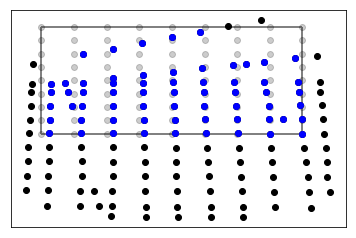

In [526]:
from functools import partial
from scipy import optimize

#optim_result = optimize.basinhopping(
#    lambda coordinates:mixed_distance(coordinates.reshape((-1, 2)), all_points),
#    x0=all_points[np.random.choice(len(all_points), 4)].ravel(),
#    niter=25, T=1.0, stepsize=10, minimizer_kwargs={'method':'Nelder-Mead'}
#)

optim_result = optimize.minimize(
    lambda coordinates:mixed_distance(coordinates.reshape((-1, 2)), all_points),
    #x0=max_corner_points.ravel(),
    x0=np.array([[100, 100], [100, 1500], [1500, 1500], [1500, 100]]).ravel(),
    method='Nelder-Mead')

print(optim_result.x.reshape((-1, 2)))
print(optim_result.fun)
output_points = detection.perspective_transform(optim_result.x.reshape((-1, 2)), all_points, output_square_size)

show_points(ideal_output_points(output_square_size), 'ok', alpha=.2, with_grid=True)
show_points(output_points, 'ok', with_grid=True)
show_points(only_inside_points(output_points, output_square_size), 'ob', with_grid=True)

## Using lines

In [368]:
result.h_lines[:10]

[[1660.0, 1.5707964],
 [1837.0, 1.5707964],
 [2389.0, 1.5707964],
 [2385.0, 1.5707964],
 [2394.0, 1.5707964],
 [1657.0, 1.5707964],
 [2018.0, 1.5707964],
 [941.0, 1.5707964],
 [943.0, 1.5707964],
 [946.0, 1.5707964]]

In [332]:
l = result.h_lines[1]

np.abs(np.cos(l[1]) * all_points[:, 0] + np.sin(l[1]) * all_points[:, 1] - l[0]) < 0.000001

array([False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

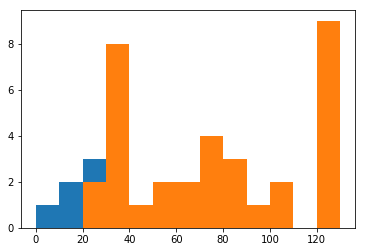

In [402]:
def line_points_intersections(lines, points):
    lines, points = np.asarray(lines), np.asarray(points) 
    cos_thetas_x = np.dot(np.cos(lines)[:, [1]], points[:, [0]].T)
    sin_thetas_y = np.dot(np.sin(lines)[:, [1]], points[:, [1]].T)
    b = np.array(lines)[:, [0]]
    return (cos_thetas_x + sin_thetas_y - b < 0.000001)

intersections = line_points_intersections(result.h_lines, result.all_points)

n_intersections_lines = intersections.sum(axis=1)

selected_mask = n_intersections_lines > 20
selected_h_lines = np.asarray(result.h_lines)[selected_mask]

plt.hist(n_intersections_lines, bins=range(0, 140, 10));
plt.hist(n_intersections_lines[selected_mask], bins=range(0, 140, 10));

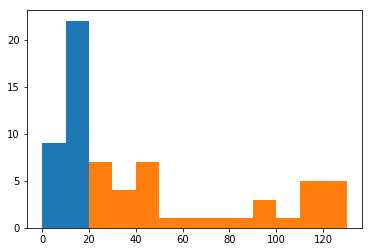

In [400]:
intersections = line_points_intersections(result.v_lines, result.all_points)

n_intersections_lines = intersections.sum(axis=1)
selected_mask = n_intersections_lines > 20
selected_v_lines = np.asarray(result.v_lines)[selected_mask]

plt.hist(n_intersections_lines, bins=range(0, 140, 10));
plt.hist(n_intersections_lines[selected_mask], bins=range(0, 140, 10));

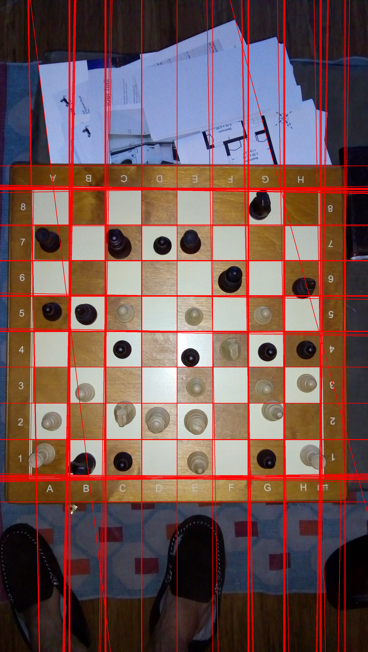

In [404]:
detection.cv_to_pil(
    detection.draw_lines(detection.cv2.imdecode(image, 1), np.concatenate([selected_v_lines, selected_h_lines])), ratio=.2)

41
13
70
26


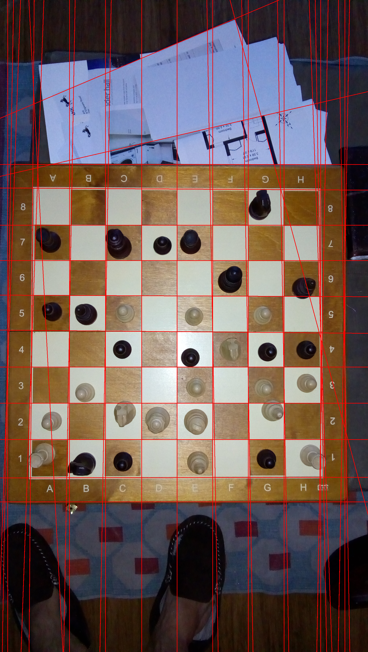

In [553]:
selected_h_lines = np.asarray(detection.cluster(result.h_lines, max_dist=20))
selected_v_lines = np.asarray(detection.cluster(result.v_lines, max_dist=20))

print(len(result.h_lines))
print(len(selected_h_lines))

print(len(result.v_lines))
print(len(selected_v_lines))


detection.cv_to_pil(
    detection.draw_lines(detection.cv2.imdecode(image, 1), np.concatenate([
        selected_h_lines, selected_v_lines])), ratio=.2)

In [554]:
selected_h_lines

array([[1.6525000e+03, 1.5795230e+00],
       [1.8370000e+03, 1.5707964e+00],
       [2.3921001e+03, 1.5690509e+00],
       [2.0180000e+03, 1.5707964e+00],
       [9.4088892e+02, 1.5766140e+00],
       [2.2000000e+03, 1.5707964e+00],
       [1.1275000e+03, 1.5707964e+00],
       [1.3045000e+03, 1.5707964e+00],
       [1.4775000e+03, 1.5751597e+00],
       [8.2300000e+02, 1.5707964e+00],
       [5.4500000e+02, 1.1693705e+00],
       [8.6000000e+02, 1.3439035e+00],
       [2.5120000e+03, 1.5707964e+00]], dtype=float32)

In [555]:
def sort_h_lines_bottom_to_top(h_lines: np.array):
    order_by_rho = np.argsort(h_lines[:, 0])
    return h_lines[order_by_rho, :]

selected_h_lines = sort_h_lines_bottom_to_top(selected_h_lines)

selected_h_lines

array([[5.4500000e+02, 1.1693705e+00],
       [8.2300000e+02, 1.5707964e+00],
       [8.6000000e+02, 1.3439035e+00],
       [9.4088892e+02, 1.5766140e+00],
       [1.1275000e+03, 1.5707964e+00],
       [1.3045000e+03, 1.5707964e+00],
       [1.4775000e+03, 1.5751597e+00],
       [1.6525000e+03, 1.5795230e+00],
       [1.8370000e+03, 1.5707964e+00],
       [2.0180000e+03, 1.5707964e+00],
       [2.2000000e+03, 1.5707964e+00],
       [2.3921001e+03, 1.5690509e+00],
       [2.5120000e+03, 1.5707964e+00]], dtype=float32)

In [556]:
selected_v_lines

array([[ 8.8500000e+02,  0.0000000e+00],
       [ 1.7109091e+02,  7.9333149e-03],
       [ 1.0630000e+03,  0.0000000e+00],
       [ 6.7250000e+01,  1.7453292e-02],
       [-1.5760000e+03,  3.1241393e+00],
       [-1.4366667e+02,  3.0892327e+00],
       [ 1.7240000e+03,  0.0000000e+00],
       [ 7.0800000e+02,  0.0000000e+00],
       [ 1.6030000e+03,  0.0000000e+00],
       [ 1.2410000e+03,  0.0000000e+00],
       [ 5.2700000e+02,  0.0000000e+00],
       [ 1.4206666e+03,  0.0000000e+00],
       [ 3.7575000e+02,  1.7453292e-02],
       [ 3.8000000e+01,  0.0000000e+00],
       [ 3.4700000e+02,  0.0000000e+00],
       [-1.6920000e+03,  3.1241393e+00],
       [-1.3870000e+03,  3.1241393e+00],
       [ 2.1900000e+02,  3.4906585e-02],
       [ 5.5600000e+02,  1.7453292e-02],
       [-1.5450000e+03,  3.1066864e+00],
       [ 1.6405000e+03,  1.7453292e-02],
       [-1.2080000e+03,  3.1241393e+00],
       [ 1.0200000e+02,  3.4906585e-02],
       [-1.1110000e+03,  2.8797932e+00],
       [ 1.74800

In [557]:
def sort_v_lines_left_to_right(v_lines: np.array):
    x_axis_line = detection.Line(rho=0, theta=np.pi/2)
    with_axis_intersections = detection.intersections(v_lines, [x_axis_line])
    left_to_right_indexes = np.argsort(np.array(with_axis_intersections)[:, 0])
    return v_lines[left_to_right_indexes]

def corner_intersections(bottom_line, top_line, left_line, right_line):
    bottom_left, bottom_right, top_left, top_right = detection.intersections(
        [bottom_line, top_line], [left_line, right_line])
    # order to match expected order for perspective transform
    return [bottom_left, top_left, top_right, bottom_right]

selected_v_lines = sort_v_lines_left_to_right(selected_v_lines)

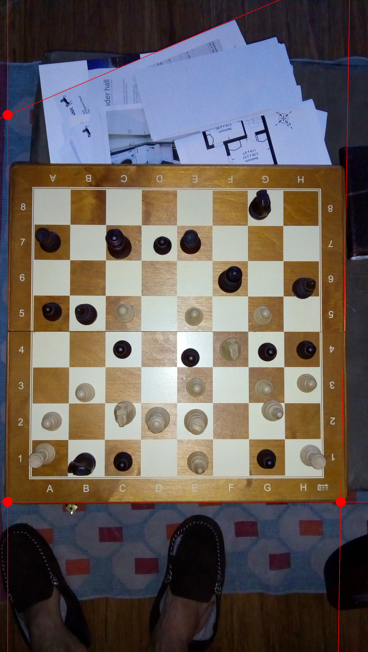

In [558]:
possible_corners = corner_intersections(*selected_h_lines[[0, -1], :], *selected_v_lines[[0, -1], :])

detection.cv_to_pil(
    detection.draw_lines(detection.draw_points(detection.cv2.imdecode(image, 1), possible_corners), np.concatenate([
        selected_h_lines[[0, -1], :], selected_v_lines[[0, -1], :]])), ratio=.2)

In [445]:
# itertools product
list(product([1, 2], [1, 2], [1, 2]))

[(1, 1, 1),
 (1, 1, 2),
 (1, 2, 1),
 (1, 2, 2),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 1),
 (2, 2, 2)]

10.59340360355661
10.59340360355661


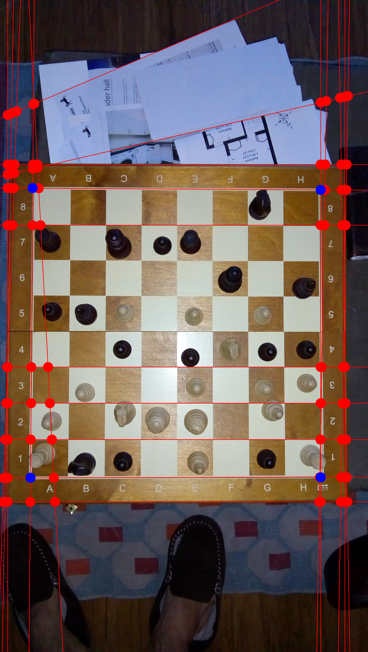

In [583]:
# cannot be lower on this example
topn = 5

borders_candidates = product(
    selected_h_lines[:topn],
    selected_h_lines[-topn:],
    selected_v_lines[:topn],
    selected_v_lines[-topn:]
)

decoded_image = detection.cv2.imdecode(image, 1)
criteria = []
best_criterium = np.infty
best_corners = None

for borders in borders_candidates:
    possible_corners = corner_intersections(*borders)
    c = mixed_distance(possible_corners, all_points)
    criteria.append(c)
    if c <= best_criterium:
        best_criterium = c
        best_corners = possible_corners
    decoded_image = detection.draw_lines(
        detection.draw_points(decoded_image, possible_corners), 
        borders)

print(min(criteria))
print(best_criterium)
detection.cv_to_pil(detection.draw_points(decoded_image, best_corners, color=(255, 0, 0)), ratio=.2)

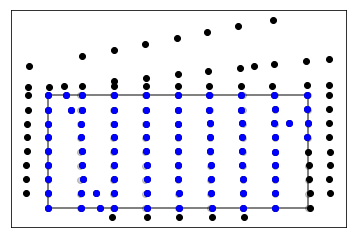

In [584]:
output_points = detection.perspective_transform(best_corners, result.all_points, output_square_size)

show_points(ideal_output_points(output_square_size), 'ok', alpha=.2, with_grid=True)
show_points(output_points, 'ok', with_grid=True)
show_points(only_inside_points(output_points, output_square_size), 'ob', with_grid=True)

In [585]:
only_inside_points(output_points, output_square_size).shape

(81, 2)

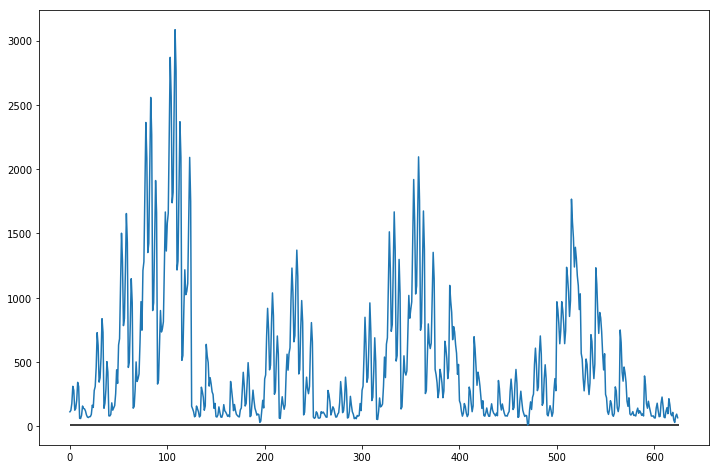

In [578]:
# surely better ways to explore the combinations of lines than just using itertools.product
plt.figure(figsize=(12, 8))
plt.plot(criteria);
plt.hlines(xmin=0, xmax=len(criteria), y=best_criterium);

points: 136
h_lines: 41 -> 13
v_lines: 70 -> 26
borders_candidates 81
best_criterium 5157.122686648512


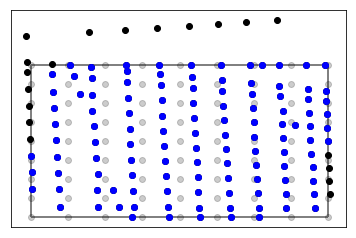

In [590]:
best_corners = detection.find_corners2(result.h_lines, result.v_lines, result.all_points, topn=5)

output_points = detection.perspective_transform(best_corners, result.all_points, output_square_size)

show_points(ideal_output_points(output_square_size), 'ok', alpha=.2, with_grid=True)
show_points(output_points, 'ok', with_grid=True)
show_points(only_inside_points(output_points, output_square_size), 'ob', with_grid=True)

In [581]:
only_inside_points(output_points, output_square_size).shape

(84, 2)

In [541]:
np.asarray(corners).tolist()

[[162.15129576856287, 1127.5000070878596],
 [151.16739087354063, 2512.0000066077387],
 [1704.4191453562205, 2512.0000745025322],
 [1728.5856825436583, 1127.500075558884]]